# Package

In [13]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import random
import tensorflow as tf
from scipy.io import loadmat
from tensorflow import keras
from keras.layers import *
from keras.models import Sequential, load_model
from keras.backend import clear_session
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

# Set a random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [14]:
# Check if TensorFlow is using GPU
print("GPU Available:", tf.test.is_gpu_available())

# Get the name of the GPU device
if tf.test.is_gpu_available():
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    gpu_name = gpu_devices[0].name if gpu_devices else "Unknown GPU"
    print("GPU Name:", gpu_name)

GPU Available: False


# Load data

In [15]:
def displacement_to_acceleration(displacement, dt):
    """
    Calculate acceleration from an array of displacement values over time.
    
    Parameters:
    - displacement: A NumPy array of displacement values.
    - dt: The time step between measurements.
    
    Returns:
    - A NumPy array of acceleration values, with the same size as the input array by padding.
    """
    # First derivative (Velocity)
    velocity = np.diff(displacement) / dt

    # Second derivative (Acceleration)
    acceleration = np.diff(velocity) / dt

    # Padding the acceleration array with zeros at the beginning and the end
    # to maintain the same size as the original displacement array.
    acceleration_padded = np.pad(acceleration, (1, 1), 'constant', constant_values=(0, 0))

    return acceleration

In [16]:

# directory = r"F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\Data"
# all_data = {}

# # Iterate over all files in the directory
# for filename in os.listdir(directory):
#     if filename.endswith('.mat'):
#         filepath = os.path.join(directory, filename)
#         # Load the .mat file and add its contents to the dictionary
#         mat_data = loadmat(filepath)
        
#         # Use filename (without extension) as key for the data
#         key = os.path.splitext(filename)[0]
#         all_data[key] = mat_data['acceleration']
#         print(filepath)

In [18]:
# keys_to_stack = [f'NamO{i}' for i in range(11)]
# input_data = np.stack([all_data[key] for key in keys_to_stack], axis=0)

# # Create the corresponding labels
# # Using 0 and 1 as class labels for binary cross-entropy
# output_labels = np.linspace(0,10,11)  
# labels = output_labels

# input_data = input_data[:,:,:50000]
# input_data.shape, output_labels.shape


disp1 = np.load('Data1_beta=0.005.npy')
disp2 = np.load('Data2_beta=0.005.npy')
disp = np.concatenate((disp1,disp2),axis = 0)
# Tạo noise
input_data = np.zeros([disp.shape[0],disp.shape[1],24998])
for i in range(disp.shape[0]):
    for j in range(disp.shape[1]):
        disp[i,j,:] = disp[i,j,:] + np.random.randn(disp.shape[2])*max(disp[i,j,:])/15000
        input_data[i,j,:] = displacement_to_acceleration(disp[i,j,:],0.01)


input_data = input_data[:,:,:24000]
output_labels = np.linspace(0,14,15)  
input_data.shape, output_labels.shape

((15, 41, 24000), (15,))

# Create folder to save results

In [7]:
# Specify the path where you want to create the new folder
folder_path = r"F:\\OneDrive\\DXLaboratory\\Papers\Quoc te\2024\Paper-2024-Aug\Result"

# Check if the folder already exists
if not os.path.exists(folder_path):
    # If the folder doesn't exist, create it
    os.makedirs(folder_path)
    print("Folder created successfully:", folder_path)
else:
    print("Folder already exists.")

# Create subfolders (Figure, Model, History) within the newly created folder
subfolders = ['Figure', 'Model', 'History', 'Data']
for subfolder in subfolders:
    subfolder_path = os.path.join(folder_path, subfolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)
        print("Subfolder '{}' created successfully.".format(subfolder))
    else:
        print("Subfolder '{}' already exists.".format(subfolder))

# Define paths for Figure, Model, and History subfolders
figure_path = os.path.join(folder_path, 'Figure')
model_path = os.path.join(folder_path, 'Model')
history_path = os.path.join(folder_path, 'History')
data_path = os.path.join(folder_path, 'Data')

NameError: name 'os' is not defined

# Augmentation

## Augmentation function

In [19]:
def augment_time_series_data(input_data, labels, num_augmentations=5):
    """
    Augment time series data.
    :param input_data: Original time series data array.
    :param labels: Corresponding labels for the data.
    :param num_augmentations: Number of augmented samples to generate per original sample.
    :return: Augmented data array and corresponding labels.
    """
    augmented_data = []
    augmented_labels = []

    num_samples, num_channels, sequence_length = input_data.shape

    for i in range(num_samples):
        for _ in range(num_augmentations):
            # Choose a random augmentation technique
            augmentation_type = random.choice(['noise', 'reverse', 'crop_pad'])

            if augmentation_type == 'noise':
                # Add random noise
                noise = np.random.normal(0, 0.001, input_data[i].shape)
                augmented_sample = input_data[i] + noise

            elif augmentation_type == 'reverse':
                # Reverse the sequence
                augmented_sample = np.flip(input_data[i], axis=-1)

            elif augmentation_type == 'crop_pad':
                # Crop and pad the sequence
                crop_size = random.randint(0, sequence_length // 100)
                padded_sample = np.pad(input_data[i], ((0, 0), (crop_size, 0)), 
                                       mode='constant', constant_values=0)
                augmented_sample = padded_sample[:, :-crop_size]

            augmented_data.append(augmented_sample)
            augmented_labels.append(labels[i])

    # Convert to numpy arrays
    augmented_data = np.array(augmented_data)
    augmented_labels = np.array(augmented_labels)

    return augmented_data, augmented_labels

# Sử dụng hàm
augmented_data, augmented_labels = augment_time_series_data(input_data, output_labels)
print(augmented_data.shape, augmented_labels.shape)

(75, 41, 24000) (75,)


## Create more data by division

In [25]:
def reshape_time_series_data_v8(input_data, label_data, 
                                segments_per_new_sample, segment_length):
    """
    Reshape time series data and corresponding labels into a specified shape.

    :param input_data: Original time series data array.
    :param label_data: Corresponding labels for the data.
    :param segments_per_new_sample: Number of segments per new sample.
    :param segment_length: Length of each segment.

    :return: Reshaped data array and corresponding labels.
    """
    num_samples_original, num_channels, length_original = input_data.shape

    # Validate the feasibility of reshaping
    if length_original % segment_length != 0:
        raise ValueError("Segment length must evenly divide the original length.")

    total_segments_per_original_sample = (length_original // 
                                          segment_length) * num_channels
    num_samples_new = (num_samples_original * 
                       total_segments_per_original_sample) // segments_per_new_sample

    # Validate if reshaping is possible
    if (num_samples_original 
        * total_segments_per_original_sample) % segments_per_new_sample != 0:
        raise ValueError("Reshaping not possible with the given dimensions.")

    # Initialize reshaped data and labels
    new_shape = (num_samples_new, segments_per_new_sample, segment_length)
    reshaped_data = np.zeros(new_shape)
    reshaped_labels = np.zeros(num_samples_new)

    # Reshape the data and labels
    count = 0
    for i in range(num_samples_original):
        segment_count = 0
        for j in range(num_channels):
            for k in range(length_original // segment_length):
                start_idx = k * segment_length
                end_idx = start_idx + segment_length
                reshaped_data[count, segment_count % 
                              segments_per_new_sample, :] = input_data[i, j, 
                                                                       start_idx:end_idx]
                if (segment_count + 1) % segments_per_new_sample == 0:
                    reshaped_labels[count] = label_data[i]  # Assign corresponding label
                    count += 1
                segment_count += 1

    return reshaped_data, reshaped_labels

# Example usage
segments_per_new_sample = 15
segment_length = 4000

# Assume 'augmented_data' and 'augmented_labels' are your input data and labels
reshaped_data, reshaped_labels = reshape_time_series_data_v8(augmented_data, 
                                                             augmented_labels, 
                                                             segments_per_new_sample, 
                                                             segment_length)
print(reshaped_data.shape, reshaped_labels.shape)

(1230, 15, 4000) (1230,)


## Save/load reshaped augmentation data

In [23]:
# Construct file paths
data_file = os.path.join(data_path, 'augmented_data.npy')
labels_file = os.path.join(data_path, 'augmented_labels.npy')

# Kiểm tra xem dữ liệu đã được lưu trước đó chưa
if not os.path.exists(data_file) or not os.path.exists(labels_file):
    # Nếu file không tồn tại, thực hiện data augmentation và lưu dữ liệu
    reshaped_data, reshaped_labels = reshape_time_series_data_v8(augmented_data,
                                                                 augmented_labels,
                                                                 segments_per_new_sample,
                                                                 segment_length)
    np.save(data_file, reshaped_data)
    np.save(labels_file, reshaped_labels)
    print(reshaped_data.shape, reshaped_labels.shape)
    print("Data augmented and saved.")

else:
    # Nếu file đã tồn tại, tải dữ liệu
    reshaped_data = np.load(data_file)
    reshaped_labels = np.load(labels_file)
    print(reshaped_data.shape, reshaped_labels.shape)
    print("Data loaded from saved files.")


NameError: name 'os' is not defined

# Data

In [27]:
# Assuming reshaped_data and reshaped_labels are defined
input_train = reshaped_data
output_train = reshaped_labels

# Split the data into training and validation sets
XX_train_reshaped, XX_valid_reshaped, y_train, y_valid = train_test_split(input_train,output_train, test_size=0.4, random_state=random_seed)

# Now, reshape XXX_train and XXX_valid from (N, 10, 5000) to (N, 5000, 10)
XX_train = XX_train_reshaped.reshape(XX_train_reshaped.shape[0], 4000, 15)
XX_valid = XX_valid_reshaped.reshape(XX_valid_reshaped.shape[0], 4000, 15)

XXX_train, XXX_test, y_train, y_test = train_test_split(XX_train, y_train, test_size=0.3, random_state=random_seed)
XXX_valid = np.concatenate((XX_valid, XXX_test))
y_valid = np.concatenate((y_valid, y_test))

label=np.unique(y_train)
num_classes = len(np.unique(y_train))

# Print the shapes to verify
print(XXX_train.shape)
print(XXX_valid.shape)
print(XXX_test.shape)

(516, 4000, 15)
(714, 4000, 15)
(222, 4000, 15)


# Model

## 1DCNN-LSTM

In [28]:
keras.backend.clear_session()
model_1DCNN_LSTM = Sequential()
model_1DCNN_LSTM.add(Conv1D(filters=86, kernel_size=3, padding="same", activation='relu', input_shape=(XXX_train.shape[1],XXX_train.shape[2])))
model_1DCNN_LSTM.add(BatchNormalization())
model_1DCNN_LSTM.add(ReLU())
model_1DCNN_LSTM.add(LSTM(64, return_sequences=True, dropout=0.5))
model_1DCNN_LSTM.add(MaxPooling1D(2))
model_1DCNN_LSTM.add(LSTM(32, return_sequences=True))
model_1DCNN_LSTM.add(MaxPooling1D(2))
model_1DCNN_LSTM.add(Flatten())
model_1DCNN_LSTM.add(Dense(32))
model_1DCNN_LSTM.add(Dense(num_classes, activation='softmax'))
model_1DCNN_LSTM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1DCNN_LSTM.summary()
history_1DCNN_LSTM = model_1DCNN_LSTM.fit(XXX_train, y_train, epochs=100, batch_size=32, validation_data=(XXX_valid, y_valid), verbose=1)

# Train the model
train_1DCNN_LSTM = history_1DCNN_LSTM.history['accuracy']
valid_1DCNN_LSTM = history_1DCNN_LSTM.history['val_accuracy']

DCNN_LSTM_valid_loss, DCNN_LSTM_valid_acc = model_1DCNN_LSTM.evaluate(XXX_valid, y_valid)

plt.figure()
plt.plot(history_1DCNN_LSTM.history['accuracy'], label='train')
plt.plot(history_1DCNN_LSTM.history['val_accuracy'], label='test')
plt.title("Accuracy Train/Val 1DCNN_LSTM")
plt.legend()

# Save the figure to the "Figure" subfolder
plt.savefig(os.path.join(figure_path, '1DCNN_LSTM2.png'))
print("Plot saved to '{}'.".format(os.path.join(figure_path, '1DCNN_LSTM2.png')))
# Save the model
model_1DCNN_LSTM.save(os.path.join(model_path, "1DCNN_LSTM2.h5"))
# Save history as a .pkl file
with open(os.path.join(history_path, 'history_1DCNN_LSTM2.pkl'), 'wb') as f:
    pickle.dump({'train_accuracy': history_1DCNN_LSTM.history['accuracy'], 'val_accuracy': history_1DCNN_LSTM.history['val_accuracy']}, f)
print("History saved to '{}'.".format(os.path.join(history_path, 'history_1DCNN_LSTM2.pkl')))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4000, 86)          3956      
                                                                 
 batch_normalization (BatchN  (None, 4000, 86)         344       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 4000, 86)          0         
                                                                 
 lstm (LSTM)                 (None, 4000, 64)          38656     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2000, 64)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 2000, 32)          1

========== CHECK TRAIN ==========
21/21 [==============================] - 5s 213ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        71
         1.0       1.00      1.00      1.00        63
         2.0       1.00      1.00      1.00        52
         3.0       1.00      1.00      1.00        62
         4.0       1.00      1.00      1.00        62
         5.0       1.00      1.00      1.00        64
         6.0       1.00      1.00      1.00        60
         7.0       1.00      1.00      1.00        43
         8.0       1.00      1.00      1.00        59
         9.0       1.00      1.00      1.00        59
        10.0       1.00      1.00      1.00        51

    accuracy                           1.00       646
   macro avg       1.00      1.00      1.00       646
weighted avg       1.00      1.00      1.00       646

Plot saved to 'F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\Result\Figure\DCNN_LSTM

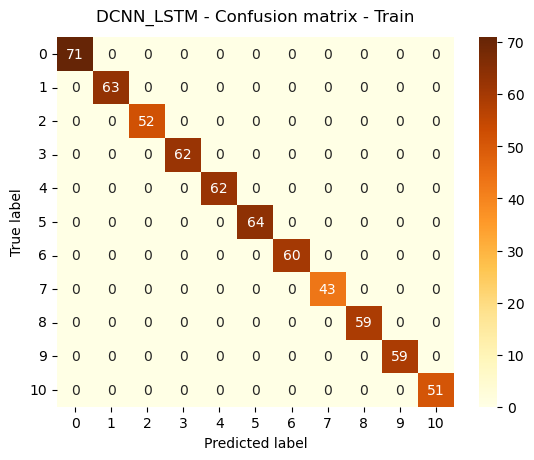

========== CHECK VALIDATE ==========
28/28 [==============================] - 8s 291ms/step
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        69
         1.0       0.99      1.00      0.99        77
         2.0       0.99      1.00      0.99        88
         3.0       1.00      1.00      1.00        78
         4.0       0.97      0.99      0.98        78
         5.0       0.96      0.96      0.96        76
         6.0       0.98      0.99      0.98        80
         7.0       1.00      0.96      0.98        97
         8.0       0.90      1.00      0.95        81
         9.0       0.99      0.95      0.97        81
        10.0       1.00      0.94      0.97        89

    accuracy                           0.98       894
   macro avg       0.98      0.98      0.98       894
weighted avg       0.98      0.98      0.98       894

Plot saved to 'F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\Result\Figure\DCNN_L

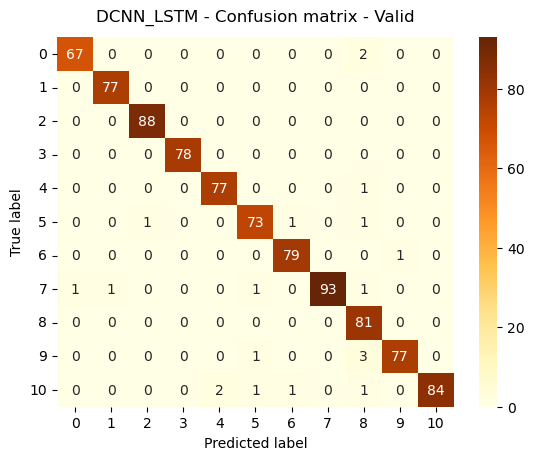

========== CHECK TEST ==========
9/9 [==============================] - 3s 295ms/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        23
         1.0       0.96      1.00      0.98        27
         2.0       1.00      1.00      1.00        21
         3.0       1.00      1.00      1.00        21
         4.0       1.00      1.00      1.00        20
         5.0       1.00      0.96      0.98        25
         6.0       0.97      1.00      0.98        29
         7.0       1.00      0.97      0.98        30
         8.0       0.96      1.00      0.98        23
         9.0       1.00      1.00      1.00        30
        10.0       1.00      0.97      0.98        29

    accuracy                           0.99       278
   macro avg       0.99      0.99      0.99       278
weighted avg       0.99      0.99      0.99       278

Plot saved to 'F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\Result\Figure\DCNN_LSTM-cf

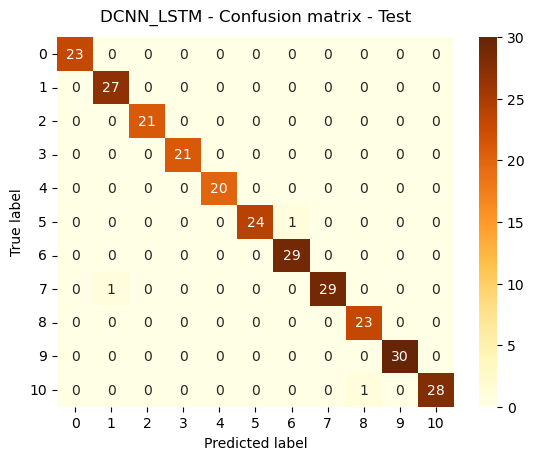

In [14]:
# check train
print("========== CHECK TRAIN ==========")
y_pred_train = model_1DCNN_LSTM.predict(XXX_train)
y_pred_bool_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, y_pred_bool_train))
cm = confusion_matrix(y_train, y_pred_bool_train)
ax=sns.heatmap(cm, annot=True, fmt='g', cmap='YlOrBr')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DCNN_LSTM - Confusion matrix - Train', y =1.02, fontsize=12)
plt.savefig(os.path.join(figure_path, 'DCNN_LSTM-cfs mt-tr2.png'))
print("Plot saved to '{}'.".format(os.path.join(figure_path, 'DCNN_LSTM2-cfs mt-tr2.png')))
plt.show()

# check validate
print("========== CHECK VALIDATE ==========")
y_pred_valid = model_1DCNN_LSTM.predict(XXX_valid)
y_pred_bool_valid = np.argmax(y_pred_valid, axis=1)
print(classification_report(y_valid, y_pred_bool_valid))
cm = confusion_matrix(y_valid, y_pred_bool_valid)
ax=sns.heatmap(cm, annot=True, fmt='g', cmap='YlOrBr')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DCNN_LSTM - Confusion matrix - Valid', y =1.02, fontsize=12)
plt.savefig(os.path.join(figure_path, 'DCNN_LSTM-cfs mt-v2.png'))
print("Plot saved to '{}'.".format(os.path.join(figure_path, 'DCNN_LSTM-cfs mt-v2.png')))
plt.show()

# check test
print("========== CHECK TEST ==========")
y_pred_test = model_1DCNN_LSTM.predict(XXX_test)
y_pred_bool_test = np.argmax(y_pred_test, axis=1)
print(classification_report(y_test, y_pred_bool_test))
cm = confusion_matrix(y_test, y_pred_bool_test)
ax=sns.heatmap(cm, annot=True, fmt='g', cmap='YlOrBr')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('DCNN_LSTM - Confusion matrix - Test', y =1.02, fontsize=12)
plt.savefig(os.path.join(figure_path, 'DCNN_LSTM-cfs mt-te2.png'))
print("Plot saved to '{}'.".format(os.path.join(figure_path, 'DCNN_LSTM-cfs mt-te2.png')))
plt.show()

# Final results

In [11]:
# Nếu file đã tồn tại, tải dữ liệu
reshaped_data2 = np.load(r"F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\NotAgu_Result\Data\not_augmented_data.npy")
reshaped_labels2 = np.load(r"F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\NotAgu_Result\Data\not_augmented_labels.npy")
print(reshaped_data.shape, reshaped_labels.shape)
print("Data loaded from saved files.")

# Assuming reshaped_data and reshaped_labels are defined
input_train2 = reshaped_data2
output_train2 = reshaped_labels2

# Split the data into training and validation sets
XX_train_reshaped2, XX_valid_reshaped2, y_train2, y_valid2 = train_test_split(input_train2,output_train2, test_size=0.4, random_state=random_seed)

# Now, reshape XXX_train and XXX_valid from (N, 10, 5000) to (N, 5000, 10)
XX_train2 = XX_train_reshaped2.reshape(XX_train_reshaped2.shape[0], 5000, 10)
XX_valid2 = XX_valid_reshaped2.reshape(XX_valid_reshaped2.shape[0], 5000, 10)

XXX_train2, XXX_test2, y_train2, y_test2 = train_test_split(XX_train2, y_train2, test_size=0.3, random_state=random_seed)
XXX_valid2 = np.concatenate((XX_valid2, XXX_test2))
y_valid2 = np.concatenate((y_valid2, y_test2))

label2=np.unique(y_train2)
num_classes2 = len(np.unique(y_train2))

# Print the shapes to verify
print(XXX_train2.shape)
print(XXX_valid2.shape)
print(XXX_test2.shape)


(1540, 10, 5000) (1540,)
Data loaded from saved files.
(128, 5000, 10)
(180, 5000, 10)
(56, 5000, 10)


In [12]:
model_path2= r"F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\NotAgu_Result\Model"
#load model
model_1DCNN = load_model(os.path.join(model_path, '1DCNN.h5'))
model_LSTM = load_model(os.path.join(model_path, 'LSTM.h5'))
model_1DCNN_LSTM = load_model(os.path.join(model_path, '1DCNN_LSTM2.h5'))
model_not_1DCNN = load_model(os.path.join(model_path2, 'not_1DCNN.h5'))
model_not_LSTM = load_model(os.path.join(model_path2, 'not_LSTM.h5'))
model_not_1DCNN_LSTM = load_model(os.path.join(model_path2, 'not_1DCNN_LSTM.h5'))

history_path2= r"F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\NotAgu_Result\History"
# load the training history
with open(os.path.join(history_path, 'history_1DCNN.pkl'), 'rb') as f:
    history_1DCNN = pickle.load(f)
with open(os.path.join(history_path, 'history_LSTM.pkl'), 'rb') as f:
    history_LSTM = pickle.load(f)
with open(os.path.join(history_path, 'history_1DCNN_LSTM2.pkl'), 'rb') as f:
    history_1DCNN_LSTM = pickle.load(f)

with open(os.path.join(history_path2, 'history_not_1DCNN.pkl'), 'rb') as f:
    history_not_1DCNN = pickle.load(f)
with open(os.path.join(history_path2, 'history_not_LSTM.pkl'), 'rb') as f:
    history_not_LSTM = pickle.load(f)
with open(os.path.join(history_path2, 'history_not_1DCNN_LSTM.pkl'), 'rb') as f:
    history_not_1DCNN_LSTM = pickle.load(f)
# 
train_1DCNN = history_1DCNN['train_accuracy']
valid_1DCNN= history_1DCNN['val_accuracy']
train_LSTM = history_LSTM['train_accuracy']
valid_LSTM = history_LSTM['val_accuracy']
train_1DCNN_LSTM = history_1DCNN_LSTM['train_accuracy']
valid_1DCNN_LSTM = history_1DCNN_LSTM['val_accuracy']

train_not_1DCNN = history_not_1DCNN['train_accuracy']
valid_not_1DCNN= history_not_1DCNN['val_accuracy']
train_not_LSTM = history_not_LSTM['train_accuracy']
valid_not_LSTM = history_not_LSTM['val_accuracy']
train_not_1DCNN_LSTM = history_not_1DCNN_LSTM['train_accuracy']
valid_not_1DCNN_LSTM = history_not_1DCNN_LSTM['val_accuracy']

DCNN_valid_loss, DCNN_valid_acc = model_1DCNN.evaluate(XXX_valid, y_valid)
LSTM_valid_loss, LSTM_valid_acc = model_LSTM.evaluate(XXX_valid, y_valid)
DCNN_LSTM_valid_loss, DCNN_LSTM_valid_acc = model_1DCNN_LSTM.evaluate(XXX_valid, y_valid)

DCNN_not_valid_loss, DCNN_not_valid_acc = model_not_1DCNN.evaluate(XXX_valid2, y_valid2)
LSTM_not_valid_loss, LSTM_not_valid_acc = model_not_LSTM.evaluate(XXX_valid2, y_valid2)
DCNN_LSTM_not_valid_loss, DCNN_LSTM_not_valid_acc = model_not_1DCNN_LSTM.evaluate(XXX_valid2, y_valid2)

6/6 [==============================] - 4s 427ms/step - loss: 1.5056 - accuracy: 0.7278


Plot saved to 'F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\Result\Figure\results train 2.png'.


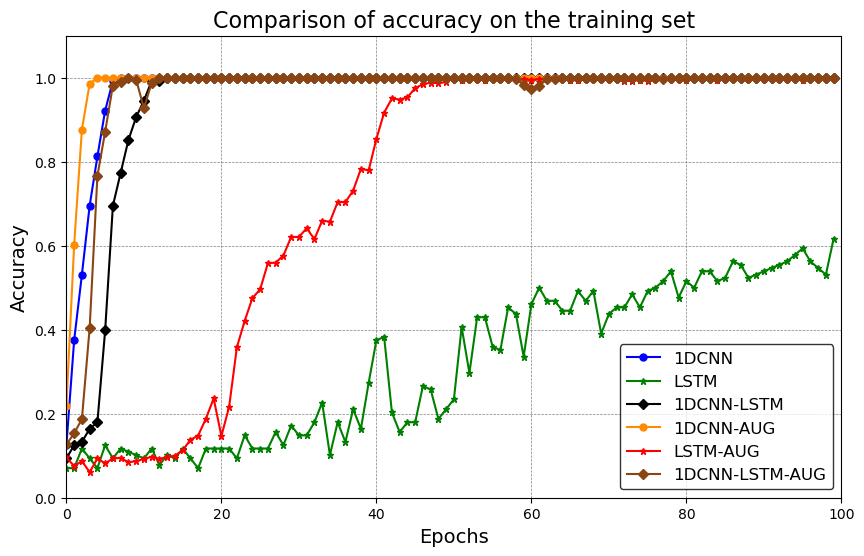

Plot saved to 'F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\Result\Figure\results valid 2.png'.


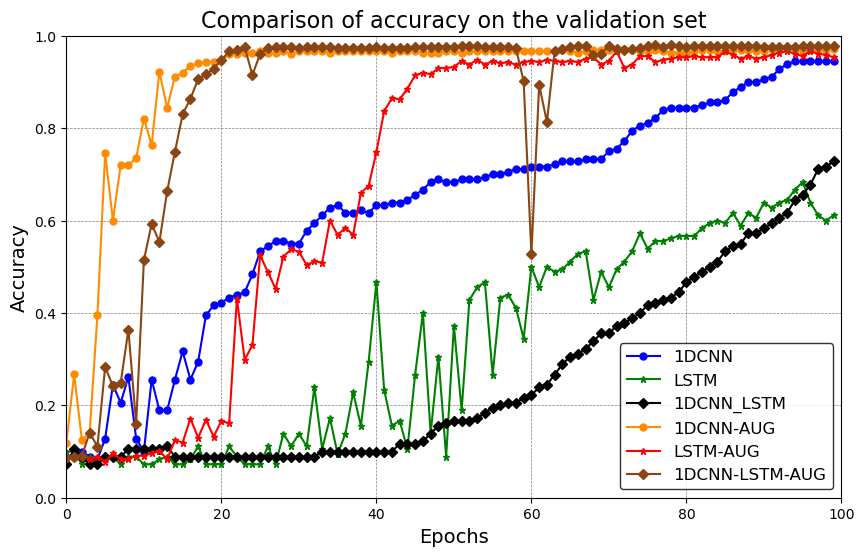

In [13]:
# plot equal 6 method
# Training set
plt.figure(figsize=(10, 6))

plt.plot(train_not_1DCNN, label='1DCNN', color='blue', marker='o',markersize=5)
plt.plot(train_not_LSTM, label='LSTM', color='green',marker='*', markersize=5)
plt.plot(train_not_1DCNN_LSTM, label='1DCNN-LSTM', color='black',marker='D', markersize=5)

plt.plot(train_1DCNN, label='1DCNN-AUG', color='darkorange', marker='o',markersize=5)
plt.plot(train_LSTM, label='LSTM-AUG', color='red',marker='*', markersize=5)
plt.plot(train_1DCNN_LSTM, label='1DCNN-LSTM-AUG', color='saddlebrown',marker='D', markersize=5)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title("Comparison of accuracy on the training set", fontsize=16)
plt.legend(loc='lower right', fontsize=12, frameon=True, edgecolor='black', facecolor='white')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=0)
plt.xlim(0, 100)
plt.ylim(0, 1.1)
plt.savefig(os.path.join(figure_path, 'results train 2.png'))
print("Plot saved to '{}'.".format(os.path.join(figure_path, 'results train 2.png')))
plt.show()

# Validation set
plt.figure(figsize=(10, 6))
plt.plot(valid_not_1DCNN, label='1DCNN', color='blue', marker='o',markersize=5)
plt.plot(valid_not_LSTM, label='LSTM', color='green',marker='*', markersize=5)
plt.plot(valid_not_1DCNN_LSTM, label='1DCNN_LSTM', color='black',marker='D', markersize=5)

plt.plot(valid_1DCNN, label='1DCNN-AUG', color='darkorange', marker='o',markersize=5)
plt.plot(valid_LSTM, label='LSTM-AUG', color='red',marker='*', markersize=5)
plt.plot(valid_1DCNN_LSTM, label='1DCNN-LSTM-AUG', color='saddlebrown',marker='D', markersize=5)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title("Comparison of accuracy on the validation set", fontsize=16)
plt.legend(loc='lower right', fontsize=12, frameon=True, edgecolor='black', facecolor='white')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=0)
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.savefig(os.path.join(figure_path, 'results valid 2.png'))
print("Plot saved to '{}'.".format(os.path.join(figure_path, 'results valid 2.png')))
plt.show()

Plot saved to 'F:\OneDrive\DXLaboratory\Papers\Quoc te\2024\Paper-2024-Aug\Result\Figure\bar valid 2.png'.


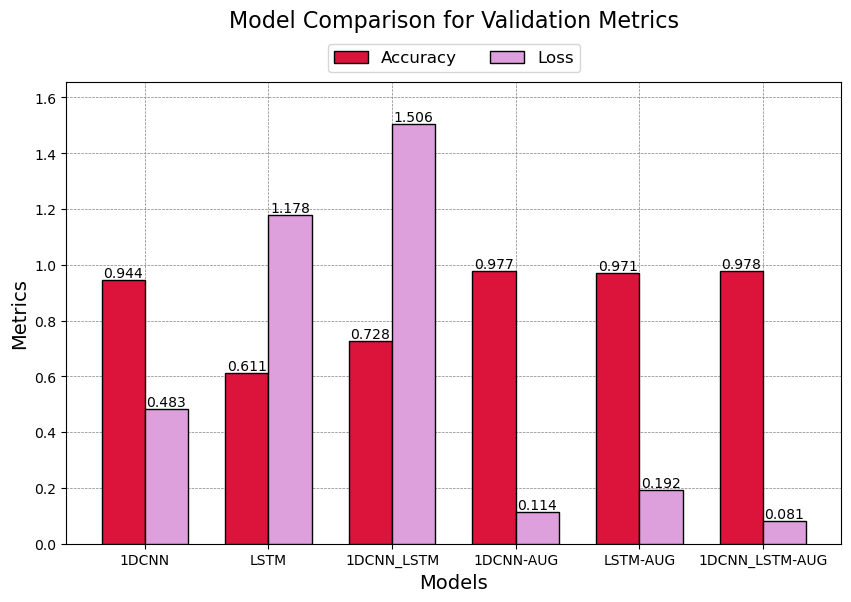

In [14]:
# Data
models = ['1DCNN', 'LSTM', '1DCNN_LSTM', '1DCNN-AUG', 'LSTM-AUG', '1DCNN_LSTM-AUG']
val_accuracy = [DCNN_not_valid_acc, LSTM_not_valid_acc, DCNN_LSTM_not_valid_acc,DCNN_valid_acc, LSTM_valid_acc, DCNN_LSTM_valid_acc]
val_loss = [DCNN_not_valid_loss, LSTM_not_valid_loss, DCNN_LSTM_not_valid_loss, DCNN_valid_loss, LSTM_valid_loss, DCNN_LSTM_valid_loss]

# Bar settings
bar_width = 0.35
index = np.arange(len(models))

# Create the plot with a scientific style
# plt.style.use('classic')
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data with zorder=3 to make sure bars are in front of grid lines
bar1 = ax.bar(index, val_accuracy, bar_width, label='Accuracy', zorder=3, color='crimson', edgecolor='black')
bar2 = ax.bar(index + bar_width, val_loss, bar_width, label='Loss', zorder=3, color='plum', edgecolor='black')

# Calculate the max height for a bar to determine text placement
max_height = max(max(val_accuracy), max(val_loss))

# Define a larger offset to move text above the top of the bars
text_offset = max_height * 0.001  # Adjust this factor as needed

# Add text above the bars
for i, rect in enumerate(bar1):
    ax.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), f'{val_accuracy[i]:.3f}', ha='center', va='bottom')

for i, rect in enumerate(bar2):
    ax.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), f'{val_loss[i]:.3f}', ha='center', va='bottom')

ax.set_ylim(0, max_height + max_height * 0.1)  # Add 10% headroom above the tallest bar for text

# Annotate the plot
ax.set_title('Model Comparison for Validation Metrics', fontsize=16, loc='center', y=1.1)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Metrics', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)

# Place the legend above the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=12)

# Add grid lines behind the bars by setting zorder=0
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=0)

plt.savefig(os.path.join(figure_path, 'bar valid 2.png'))
print("Plot saved to '{}'.".format(os.path.join(figure_path, 'bar valid 2.png')))

# Show the plot
plt.show()